#ENVIRONMENT SETUP

**INSTALLING DEPENDENCIES**

In [ ]:
!pip install transformers
!pip install datasets
!pip install tensorflow
!pip install numpy
!pip install wave
!pip install matplotlib
!pip install scipy
!pip install librosa
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wave: filename=Wave-0.0.2-py3-none-any.whl size=1219 sha256=f97762c718fe561b39dd60e82b6777676b96326a35feae9cf207be6ae6d89c19
  Stored in directory: /root/.cache/pip/wheels/f8/24/4d/1b01c0e32da3eb3fd71bbbc6093fcc557ec3b2d9e532ecd65d
Successfully built wave


**IMPORTING DEPENDENCIES**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.fftpack import fft, fftfreq, ifft
import scipy.io.wavfile as wavfile
import scipy.signal as signal
import librosa
import librosa.display
import pandas as pd
import tensorflow as tf
# from tf.keras.utils import plot_model
import random
import shutil
import os
from sklearn.model_selection import train_test_split

In [ ]:
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# LOADING THE DATASET

**MOUNTING DRIVE**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
if os.path.isdir("dataset/")==0:
  src="drive/MyDrive/Dataset (Audio Detection)"
  dest="dataset/"
  shutil.copytree(src,dest)

**CREATING THE DATASET**

In [ ]:
# Define the root directory
root_dir = 'dataset'

# Initialize empty lists to store data
paths = []
is_valid = []

# Define function to randomly select files
def random_files(folder_path, num_files):
    files = os.listdir(folder_path)
    selected_files = random.sample(files, min(num_files, len(files)))
    return selected_files

# Iterate through each subfolder
for folder in ['Human Spoken', 'Machine Spoken']:
    for subset in ['test', 'train', 'validation']:
        subset_path = os.path.join(root_dir, folder, subset)
        selected_files = random_files(subset_path, 50)
        for filename in selected_files:
            file_path = os.path.join(subset_path, filename)
            paths.append(file_path)
            is_valid.append(1 if folder == 'Human Spoken' else 0)

# Create DataFrame
data = pd.DataFrame({'path': paths, 'isValid': is_valid})

# Split the data based on source (test, train, validation)
test_data = data[data['path'].str.contains('test')]
train_val_data = data[~data['path'].str.contains('test')]

# Further split train_val_data into training and cross-validation
train_data, cv_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

# Display the size of each split
print("Size of Training Set:", len(train_data))
print("Size of Testing Set:", len(test_data))
print("Size of Cross-Validation Set:", len(cv_data))

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
cv_data = cv_data.reset_index(drop=True)

# Optional: Save splits to CSV files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)
cv_data.to_csv('cv_data.csv', index=False)



Size of Training Set: 160
Size of Testing Set: 100
Size of Cross-Validation Set: 40


# FETCHING FFT

In [ ]:
test_data

,path,isValid
0,dataset/Human Spoken/test/common_voice_en_1852...,1
1,dataset/Human Spoken/test/common_voice_en_5960...,1
2,dataset/Human Spoken/test/common_voice_en_1052...,1
3,dataset/Human Spoken/test/common_voice_en_1787...,1
4,dataset/Human Spoken/test/common_voice_en_1784...,1
...,...,...
95,dataset/Machine Spoken/test/always_common_voic...,0
96,dataset/Machine Spoken/test/alvin_common_voice...,0
97,dataset/Machine Spoken/test/always_common_voic...,0
98,dataset/Machine Spoken/test/always_common_voic...,0


**LOADING AUDIO FILE**

In [ ]:
train = train_data
train["path"][0]

'dataset/Human Spoken/validation/common_voice_en_18311707.wav'

16000


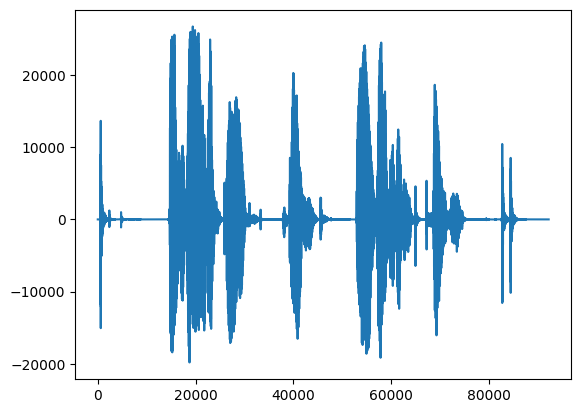

In [ ]:
path=train["path"][0]
sampling_freq, signal_data = wavfile.read(path)
print(sampling_freq)
plt.plot(signal_data)

##APPROACH B: USING LIBROSA

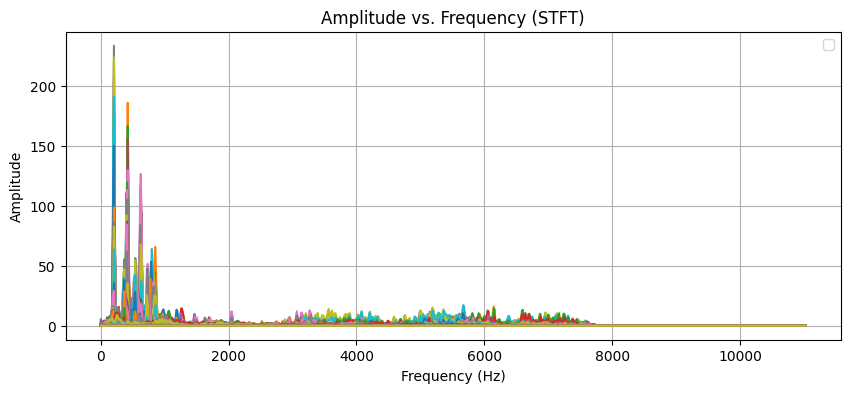

In [ ]:
path=train["path"][0]
y, sr = librosa.load(path)
n_fft = 2048
stft = librosa.core.stft(y, n_fft=2048, hop_length=512)
stft_magnitude = np.abs(stft)
frequencies = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)

plt.figure(figsize=(10, 4))
for i in range(stft_magnitude.shape[1]):
    plt.plot(frequencies, stft_magnitude[:, i])

plt.title('Amplitude vs. Frequency (STFT)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


**DEFINING A FUNCTION TO PLOT STFTs**

In [ ]:
def stftPlot(path):
  y, sr = librosa.load(path)
  n_fft = 2048
  stft = librosa.core.stft(y, n_fft=2048, hop_length=512)
  stft_magnitude = np.abs(stft)
  frequencies = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)

  plt.figure(figsize=(10, 4))
  for i in range(stft_magnitude.shape[1]):
      plt.plot(frequencies, stft_magnitude[:, i], label=f'Time Bin {i + 1}')

  plt.title('Amplitude vs. Frequency (STFT)')
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Amplitude')
  plt.legend()
  plt.grid()
  plt.show()

  return

**DEFINING A FUNCTION TO RETURN AMPLITUDE OF FREQUENCIES**

In [ ]:
def stft(path):
  y, sr = librosa.load(path)
  n_fft = 2048
  stft = librosa.core.stft(y, n_fft=2048, hop_length=512)
  stft_magnitude = np.abs(stft)
  frequencies = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)

  return stft

#FETCHING MFCC

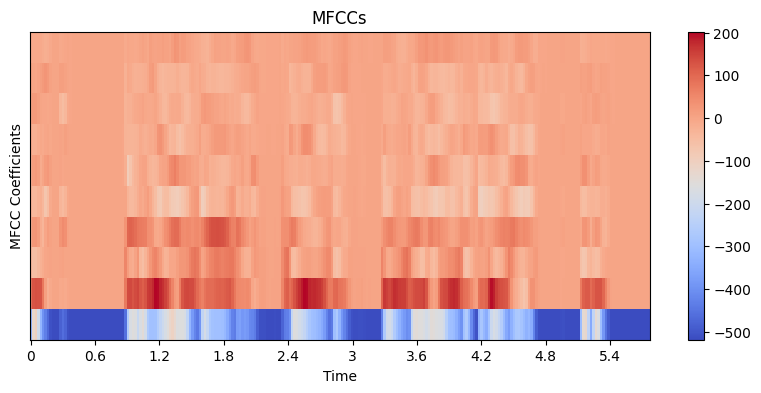

In [ ]:
path=train["path"][0]
y, sr = librosa.load(path)

mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)

# Display the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

**DEFINING A FUNCTION TO PLOT MFCC**

In [ ]:
def mfccPlot(path):
  y, sr = librosa.load(path)

  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)

  # Display the MFCCs
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(mfccs, x_axis='time')
  plt.colorbar()
  plt.title('MFCCs')
  plt.xlabel('Time')
  plt.ylabel('MFCC Coefficients')
  plt.show()

  return

**DEFINING A FUNCTION TO GET MFCC FEATURE**

In [ ]:
def mfcc(path):
  y, sr = librosa.load(path)

  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)

  return mfccs

#FETCHING THE FEATURES

**DEFINING A FUNCTION TO FETCH BOTH MFCC AND STFT**

In [ ]:
def fetchFeatures(path):
  # mfcc_features = mfcc(path)
  stft_features = stft(path)
  # combined_features = np.concatenate((mfcc_features, stft_features))
  return stft_features

**CALLING THE CODE FOR ALL THE AUDIO FILES**

In [ ]:
train_feature = []

for i in range(len(train)):
    # print(i)
    path = train["path"][i]  # Access the "path" attribute using square brackets
    temp = fetchFeatures(path)
    train_feature.append(temp)

In [ ]:
max_shape = max(arr.shape for arr in train_feature)  # Find the maximum shape
padded_arrays = [np.pad(arr, ((0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])), mode='constant') for arr in train_feature]
arr = np.array(padded_arrays)
arr.shape
# arr

(160, 1025, 2222)

In [ ]:
test_feature = []
test = test_data

for i in range(len(test)):
    # print(i)
    path = test["path"][i]  # Access the "path" attribute using square brackets
    temp = fetchFeatures(path)
    test_feature.append(temp)

In [ ]:
max_shape = max(arr2.shape for arr2 in test_feature)  # Find the maximum shape
padded_arrays = [np.pad(arr2, ((0, max_shape[0] - arr2.shape[0]), (0, max_shape[1] - arr2.shape[1])), mode='constant') for arr2 in test_feature]
arr2 = np.array(padded_arrays)
arr2.shape

(100, 1025, 1285)

#DESIGNING THE NEURAL NETWORK ARCHITECTURE

**FETCHING INPUT**

In [ ]:
x_train = arr
num_samples, num_time_steps, num_fft_bins = x_train.shape
x_train_reshaped = np.reshape(x_train, (num_samples, -1, num_fft_bins))
num_fft_bins = x_train[0].shape[1]
y_train = train["isValid"]
x_test = arr2
num_samples2,num_time_steps2, num_fft_bins2 = x_test.shape
x_test_reshaped = np.reshape(x_test, (num_samples2, -1, num_fft_bins2))
y_test = test["isValid"]

In [ ]:
x_test_reshaped.shape

(100, 1025, 1285)

In [ ]:
x_train_reshaped.shape

(160, 1025, 2222)

In [ ]:
shape_train = x_train_reshaped.shape
shape_test = x_test_reshaped.shape

# Calculate the difference in shape along the third axis
pad_width = shape_train[2] - shape_test[2]

# Calculate the padding amounts for the left and right sides
left_pad = pad_width // 2
right_pad = pad_width - left_pad

# Pad array B along the third axis
x_test_final = np.pad(x_test_reshaped, [(0, 0), (0, 0), (left_pad, right_pad)], mode='constant')

# Check the shape of B_padded
print("Shape of B_padded:", x_test_final.shape)

Shape of B_padded: (100, 1025, 2222)


**MODEL ARCHITECTURE**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(num_time_steps, num_fft_bins)),  # Input layer with the shape of the time steps and FFT bins
    tf.keras.layers.Flatten(),  # Flatten the input to make it compatible with Dense layers
    tf.keras.layers.Dense(128, activation='relu'),  # Increase the number of units in the dense layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(128, activation='relu'),  # Another dense layer
    tf.keras.layers.Dropout(0.5),  # Another dropout layer
    tf.keras.layers.Dense(64, activation='relu'),  # Another dense layer
    tf.keras.layers.Dropout(0.5),  # Another dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with binary classification
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2277550)           0         
                                                                 
 dense (Dense)               (None, 128)               291526528 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

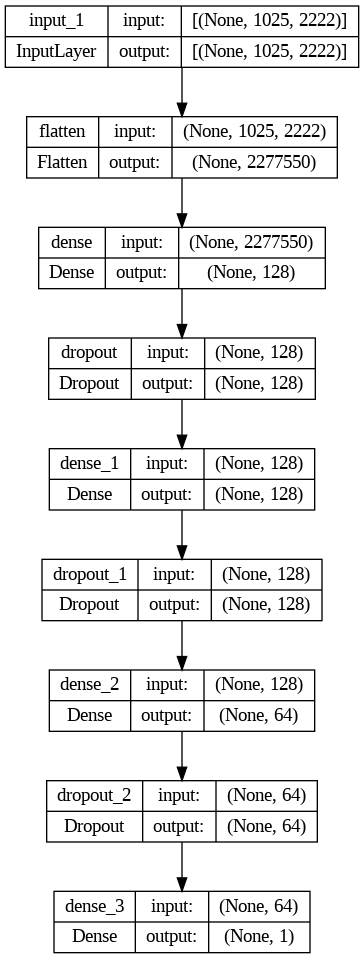

In [ ]:


tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**TRAINING THE MODEL**

In [ ]:
model.fit(x_train_reshaped, y_train, epochs=5, batch_size=16)

**MODEL EVALUATION**

In [ ]:
loss, accuracy = model.evaluate(x_test_final, y_test)
print(f'Test accuracy: {accuracy}')